In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv


In [2]:
# IMPORTING THE REQUIRED LIBRARIES
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import re
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
from numpy.fft import *
%matplotlib inline

Using TensorFlow backend.


In [3]:
# IMPORTING THE DATASET
train_1= pd.read_csv("../input/web-traffic-time-series-forecasting/train_1.csv")
train_2= pd.read_csv("../input/web-traffic-time-series-forecasting/train_2.csv")
key_1= pd.read_csv("../input/web-traffic-time-series-forecasting/key_1.csv")
key_2= pd.read_csv("../input/web-traffic-time-series-forecasting/key_2.csv")

In [4]:
# REPLACING THE MISSING VALUES TO 0
train_1= train_1.fillna(0)
train_2= train_2.fillna(0)

In [5]:
# FUNCTION FOR CREATING ANOTHER COLUMN IN TRAIN DATASET FOR THE PAGE LANGAUGE
def find_lang(page):
    res= re.search("[a-z][a-z].wikipedia.org", page)
    if res:
        return res[0][0:2]
    return("na")

train_1["lang"]= train_1.Page.map(find_lang)

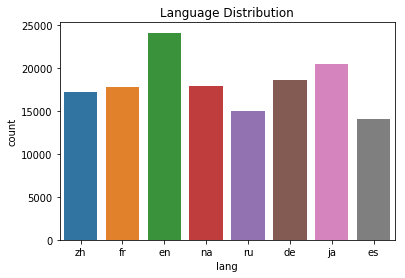

In [6]:
# PLOT FOR NUMBER OF PAGES WITH SPECIFIC LANGAUGES
sns.countplot(train_1["lang"])
plt.title("Language Distribution")
plt.show()

In [7]:
# CREATING DICTIONARY WITH DATASETS REATED TO PARTICULAR LANGUAGE TAKING KEY AS LANGUAGE
lang_set= {}
lang_set["en"]= train_1[train_1.lang=="en"].iloc[:,0:-1]
lang_set["ja"]= train_1[train_1.lang=="ja"].iloc[:,0:-1]
lang_set["de"]= train_1[train_1.lang=="de"].iloc[:,0:-1]
lang_set["na"]= train_1[train_1.lang=="na"].iloc[:,0:-1]
lang_set["fr"]= train_1[train_1.lang=="fr"].iloc[:,0:-1]
lang_set["zh"]= train_1[train_1.lang=="zh"].iloc[:,0:-1]
lang_set["ru"]= train_1[train_1.lang=="ru"].iloc[:,0:-1]
lang_set["es"]= train_1[train_1.lang=="es"].iloc[:,0:-1]

In [8]:
sums= {}
for key in lang_set:
    sums[key]= lang_set[key].iloc[:,1:].sum(axis= 0) / lang_set["en"].shape[0]

In [9]:
sums["en"]

2015-07-01    3513.862203
2015-07-02    3502.511407
2015-07-03    3325.357889
2015-07-04    3462.054256
2015-07-05    3575.520035
                 ...     
2016-12-27    6040.680728
2016-12-28    5860.227559
2016-12-29    6245.127510
2016-12-30    5201.783018
2016-12-31    5127.916418
Length: 550, dtype: float64

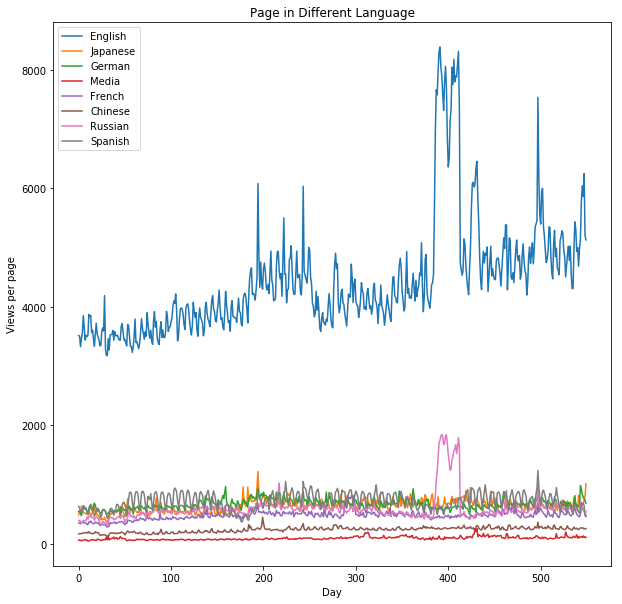

In [10]:
# PLOTTING THE PLOT FOR TOTAL TRAFFIC ON PARTICULAR LANGUAGED PAGE
days= [r for r in range(sums["en"].shape[0])]
fig= plt.figure(1, figsize= [10,10])
plt.ylabel("Views per page")
plt.xlabel("Day")
plt.title("Page in Different Language" )
label= {"en":"English", "ja":"Japanese", "de":"German", "na": "Media",
       "fr": "French", "zh": "Chinese", "ru": "Russian", "es": "Spanish"}
for key in sums:
    plt.plot(days, sums[key], label= label[key])
    
plt.legend()
plt.show()
       

**Conclusion**
* From the above graph we can see that pages in english lanuage has far more views then others.
* Also, we see the curve pointng toward upwards for english only, Only some strange behaviour is shows ona round 200 and 400 days.
* At secong spot comes the russian language plot.


**Periodic Structure and FFT**

In [11]:
"""from scipy.fftpack import fft
def plot_with_fft(key):
    fig= plt.figure(1, figsize= [15,5])
    plt.ylabel("Views Per Page")
    plt.xlabel("Day")
    plt.title(label[key])
    plt.plot(days, sums[key], label= labels[key])
    
    fig= plt.figure(2, figsize= [15, 5])
    fft_complex= fft(sums[key])
    fft_mag- [np.sqrt(np.real(x)*np.real(x)+ np.imag(x) * np.imag(x)) for x in fft_complex]
    fft_xvals= [day/day[-1] for day in days]
    npts= len(fft_xvals)//2+1
    """

'from scipy.fftpack import fft\ndef plot_with_fft(key):\n    fig= plt.figure(1, figsize= [15,5])\n    plt.ylabel("Views Per Page")\n    plt.xlabel("Day")\n    plt.title(label[key])\n    plt.plot(days, sums[key], label= labels[key])\n    \n    fig= plt.figure(2, figsize= [15, 5])\n    fft_complex= fft(sums[key])\n    fft_mag- [np.sqrt(np.real(x)*np.real(x)+ np.imag(x) * np.imag(x)) for x in fft_complex]\n    fft_xvals= [day/day[-1] for day in days]\n    npts= len(fft_xvals)//2+1\n    '

* Down below we are creating simple lstm model with the fourier transformed values

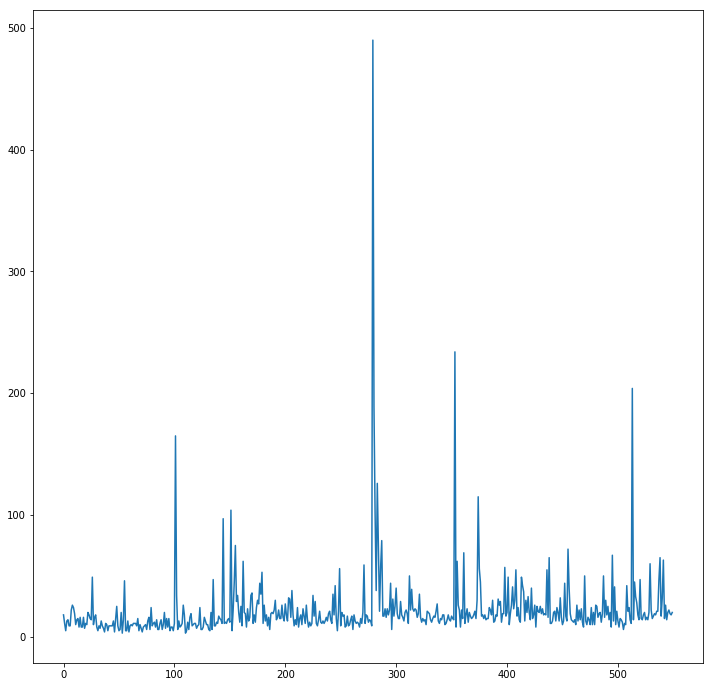

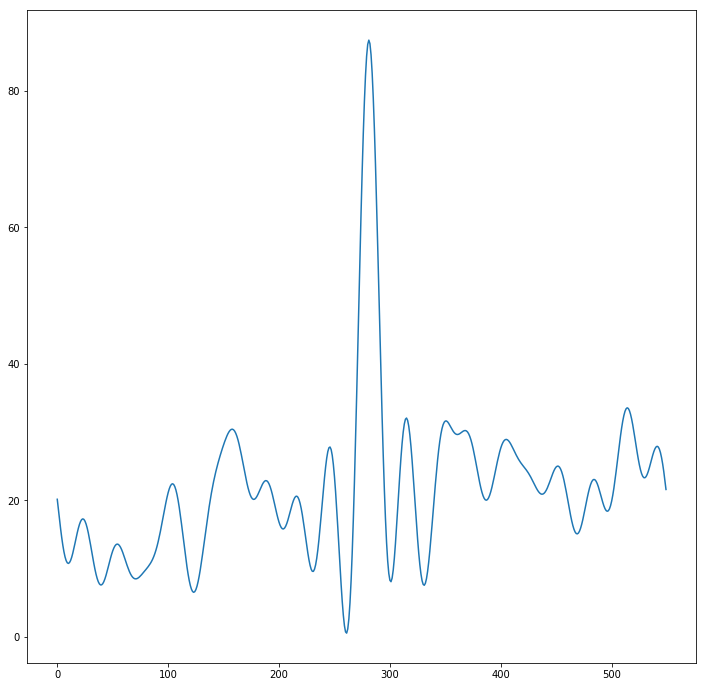

In [12]:
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

a= np.array(train_1.iloc[0,1:-1],np.float32)
sc= MinMaxScaler()

plt.figure(figsize= (12,12))
plt.plot(a)
plt.show()

plt.figure(figsize= (12,12))
plt.plot(filter_signal(a))
plt.show()

regressor= Sequential()
regressor.add(LSTM(units= 10, activation="relu",return_sequences=True, input_shape=(None, 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer= "adam", loss= "mean_squared_error")

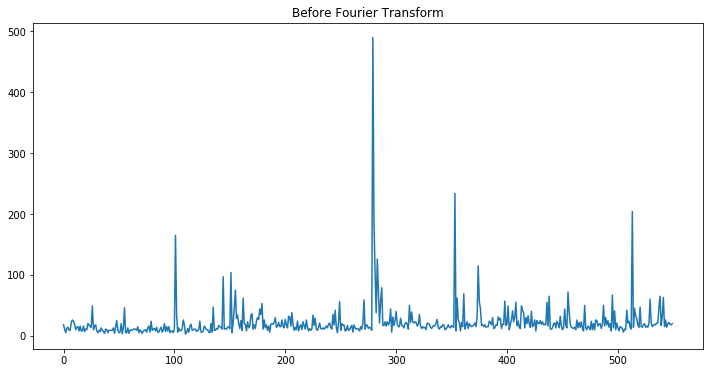

In [13]:
a= np.array(train_1.iloc[0,1:-1],np.float32)

plt.figure(figsize= (12, 6))
plt.title("Before Fourier Transform")
plt.plot(a)

Text(0.5, 1.0, 'After Fourier Transform')

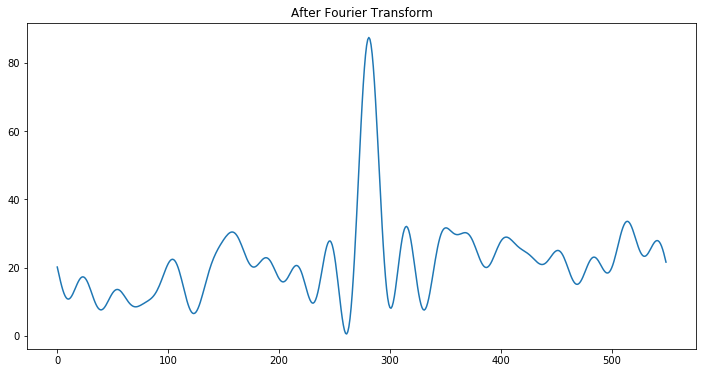

In [14]:
plt.figure(figsize= (12,6))
plt.plot(filter_signal(a))
plt.title("After Fourier Transform")

In [15]:
# Perparing LSTM neural network
regressor= Sequential()
regressor.add(LSTM(units= 10, activation="relu",return_sequences=True, input_shape=(None, 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer= "adam", loss= "mean_squared_error")

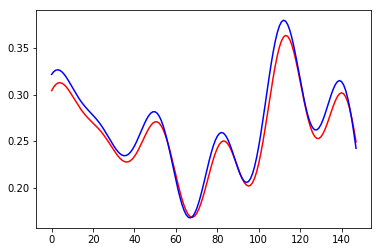

In [16]:
# Transforing array value to discrete fourier coeff.
arr= filter_signal(a)
arr= arr.reshape(-1,1)

# performing standardization of values using min max scaler
arr= sc.fit_transform(arr)
arr= np.reshape(arr, (-1,1,1))

# Train data
arr_X= arr[:400]
arr_y= arr[1:401]
arr_X= np.reshape(arr_X, (-1,1,1))

# Test data
arr_TX= arr[401:-1]
arr_ty= arr[402:]
arr_TX= np.reshape(arr_TX, (-1,1,1))

# Training the model
regressor.fit(arr_X, arr_y, batch_size= 5, epochs= 100, verbose= 0)

# perdicting the value
res= regressor.predict(arr_TX)

# Reshaping the value for plotting purpose
res= res.reshape(148,1)
arr_ty= arr_ty.reshape(148,1)

#plotting the data
plt.plot(res, color="r")
plt.plot(arr_ty, color="b")
plt.show()

**Individual Entry Data**

In [17]:
def plot_entry(key, idx):
    data= lang_set[key].iloc[idx,1:]
    fig= plt.figure(1, figsize= (10, 5))
    plt.plot(days, data)
    plt.xlabel("day")
    plt.ylabel("views")
    plt.title(train_1.iloc[lang_set[key].index[idx],0])
    
    plt.show()

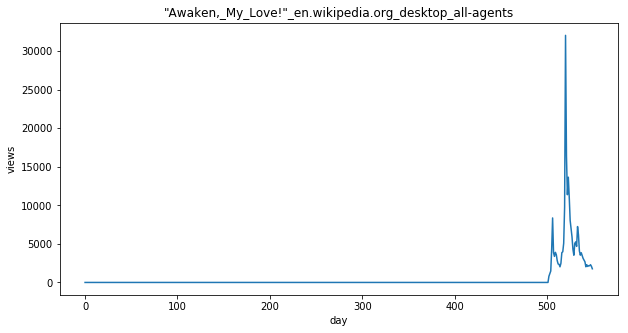

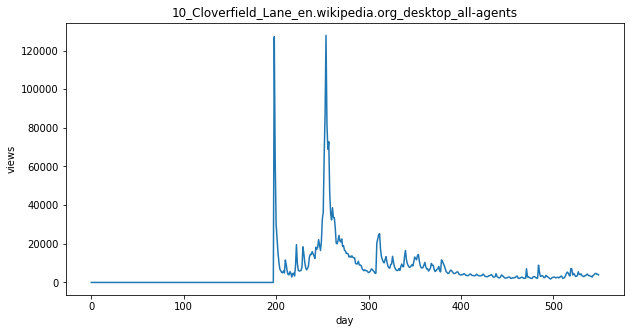

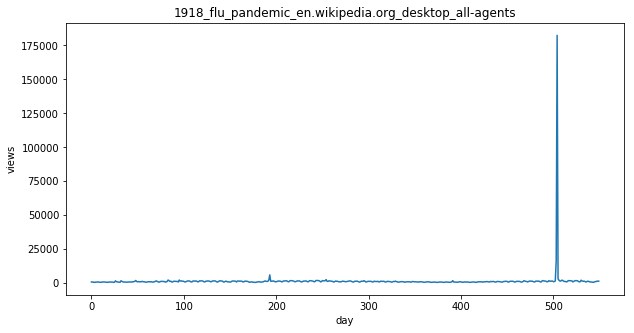

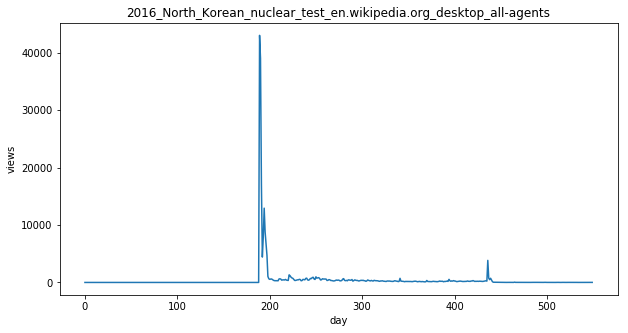

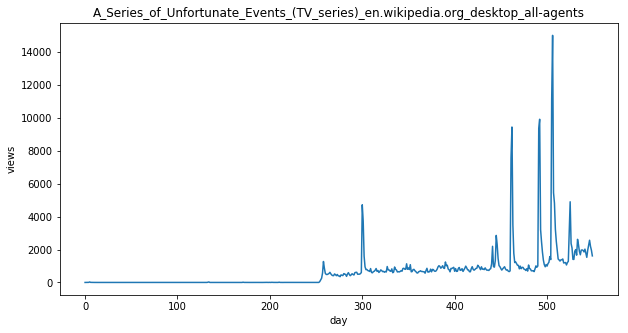

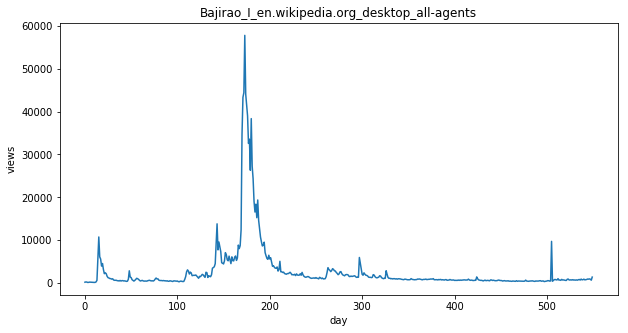

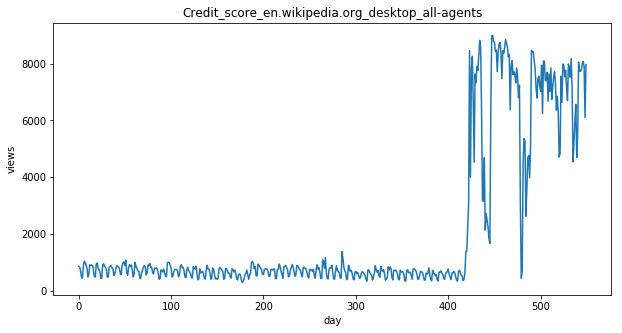

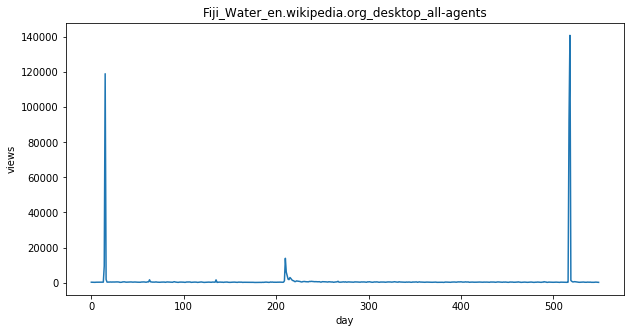

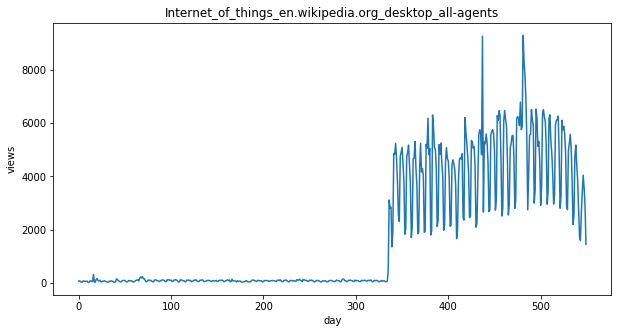

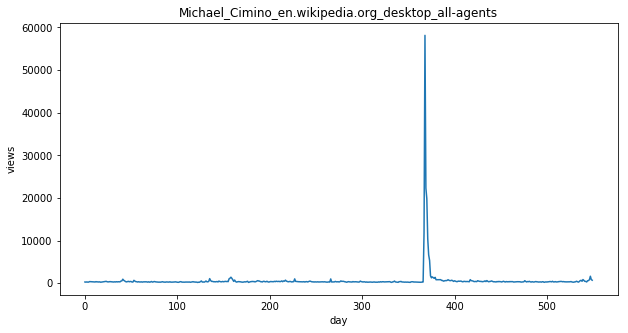

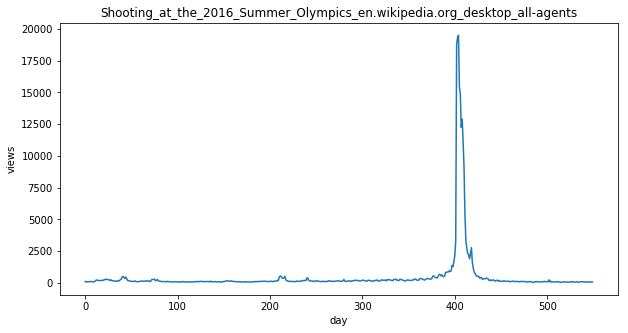

In [18]:
idx= [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000]
for i in idx:
    plot_entry("en",i)

**Notes**
* From the above graphs we can see there is some smooth curve and suddenly there some spikes occuring.
* This can be due to certain events happending related to the particular pange on the date, the reason of spike


**Now Let's look at the Spanish data**

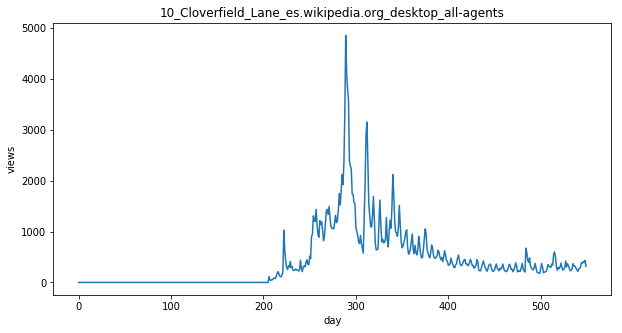

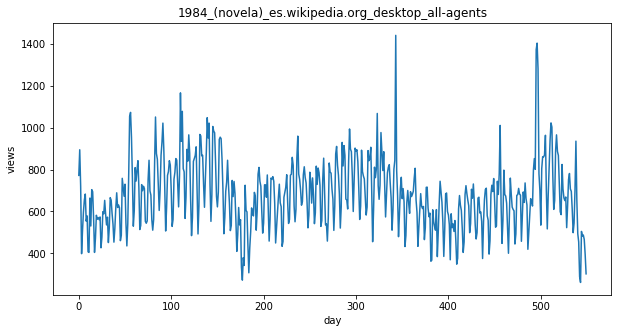

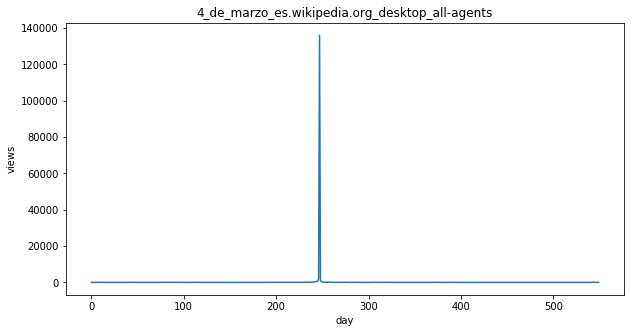

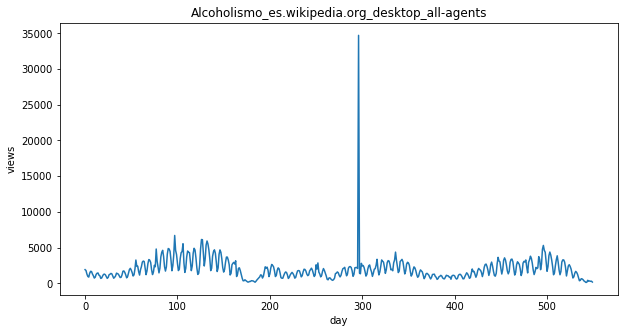

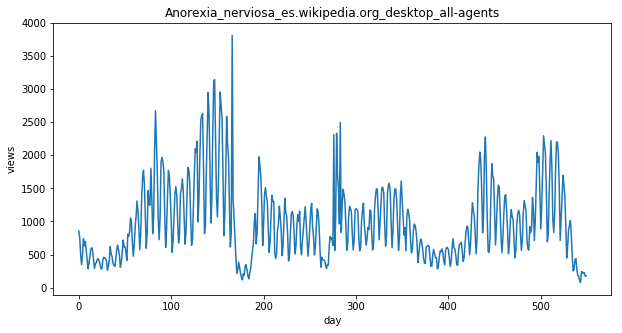

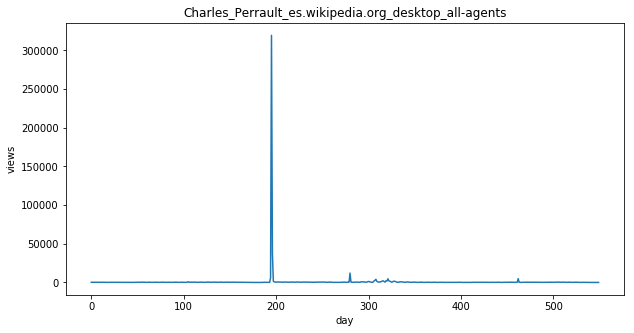

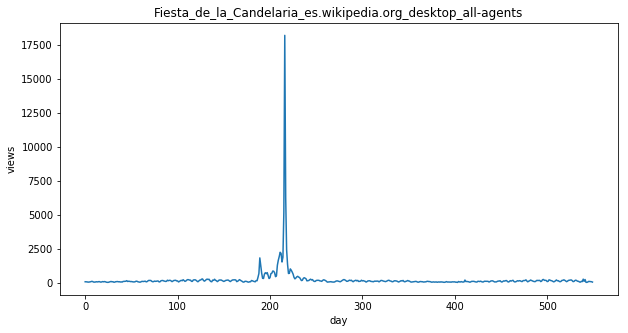

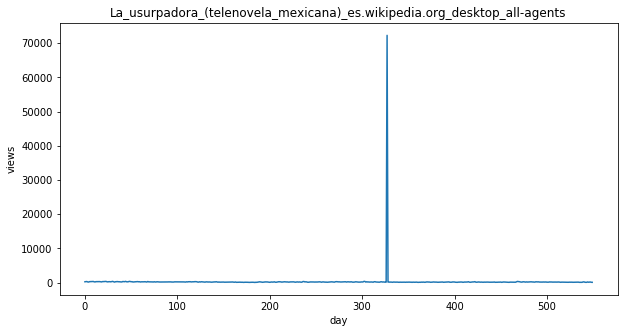

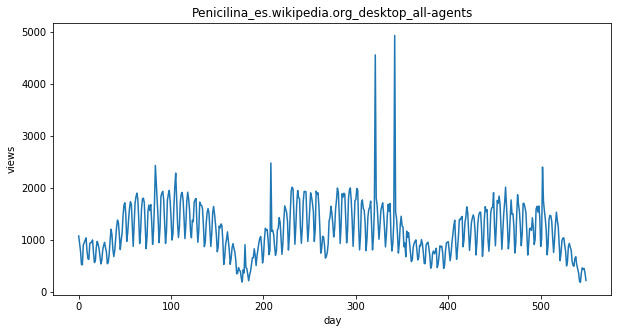

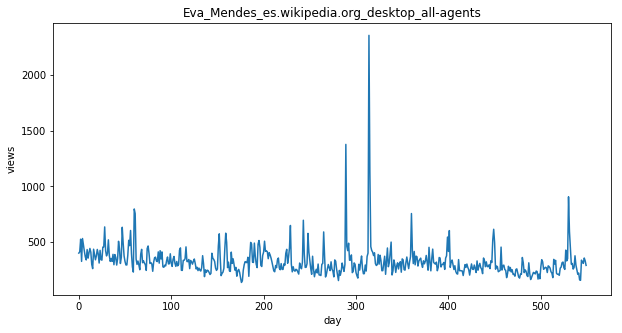

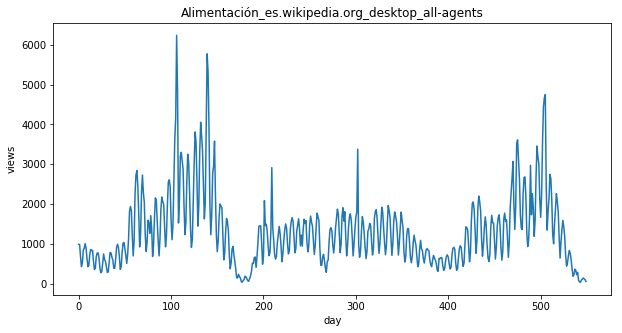

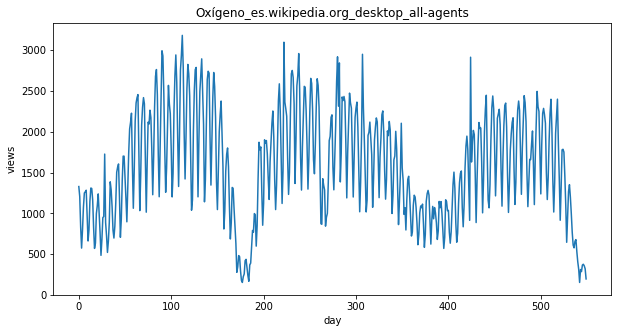

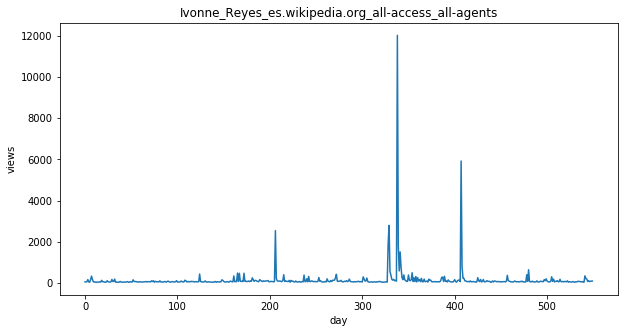

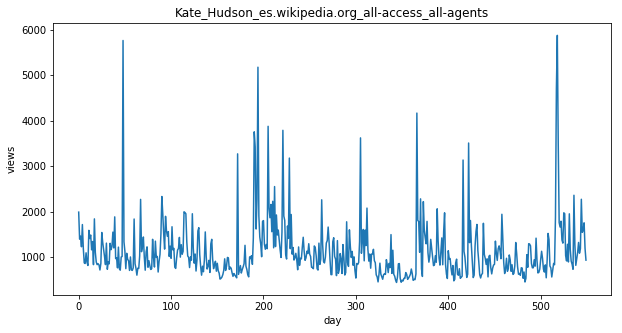

In [19]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('es',i)

**Notes**

* This shows even more extreme short-term spikes than the English data. If some of these are just one or two days before reverting back to the mean, they may be a sign that something is wrong with the data. To deal with extremely short spikes, which we almost certainly won't be able to predict, something like a median filter can be used to remove them.

**Let's look at the French data**

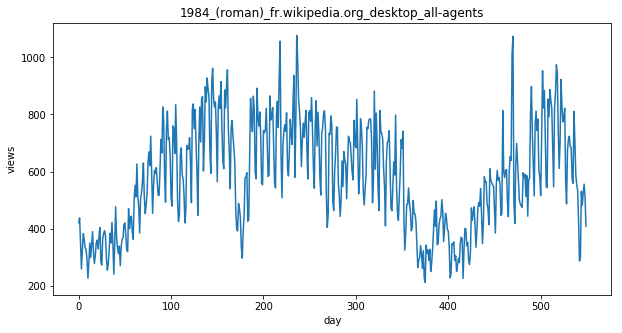

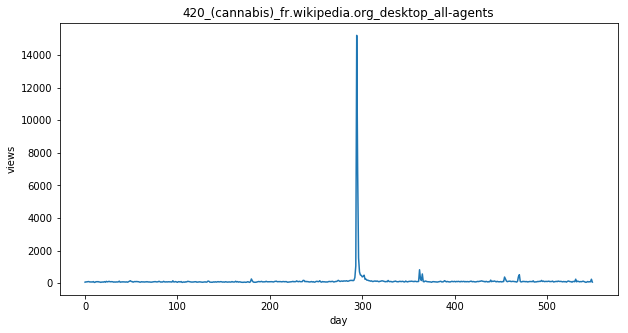

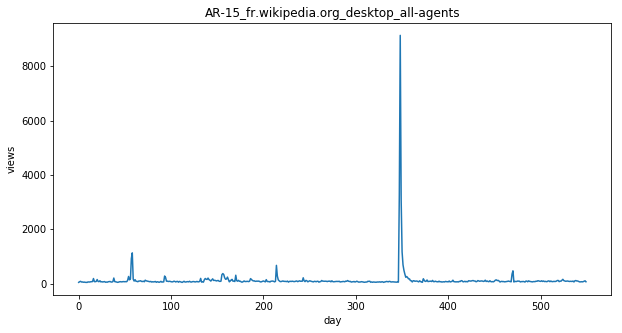

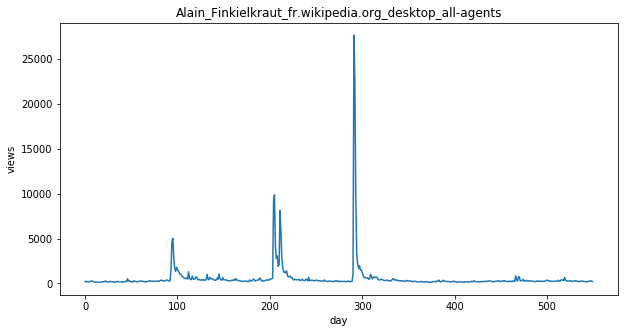

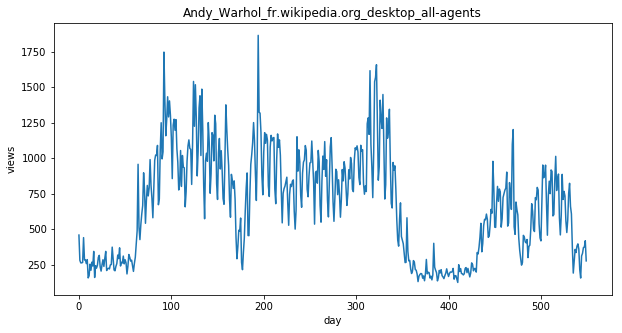

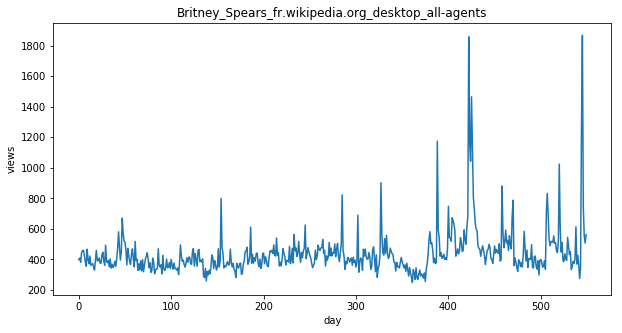

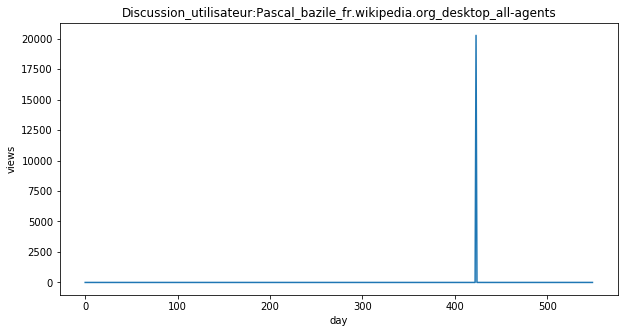

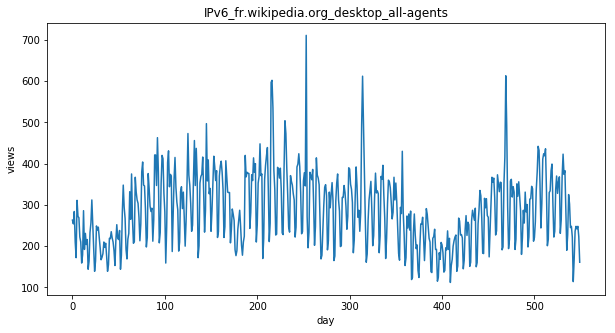

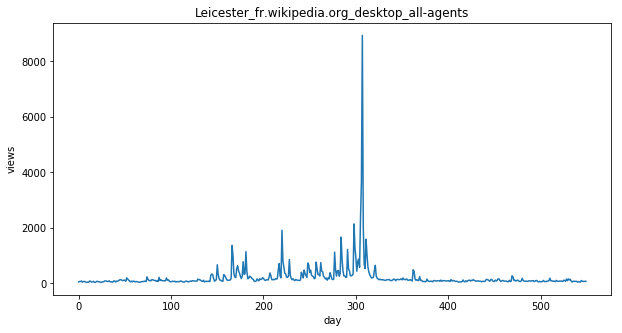

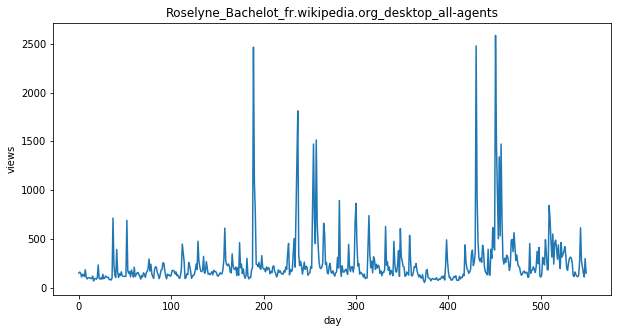

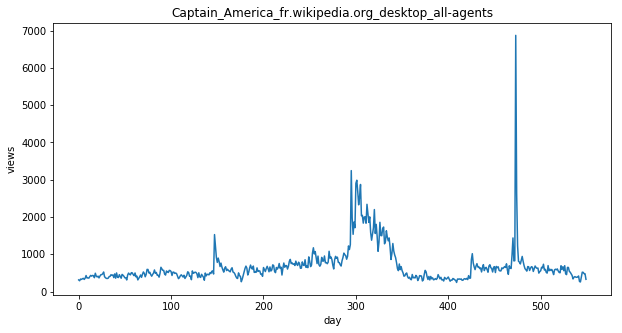

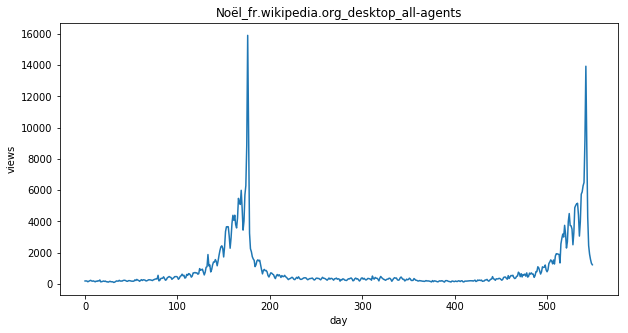

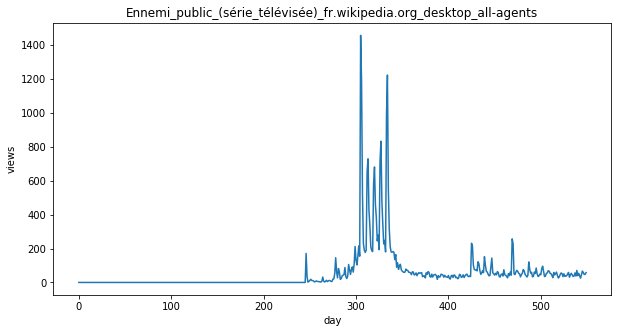

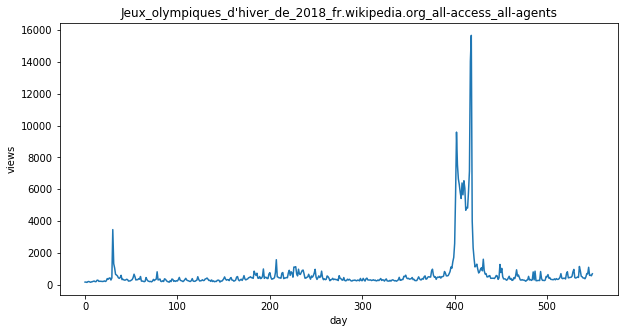

In [20]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('fr',i)


* The French plots show more of the same. Wikipedia views again are hugely dependent on whether or not something is in the news. Leicester FC won the Premier League and received many page views around the championship. The Olympics caused a huge spike in traffic to their page. Christmas actually shows some interesting structure, with views steadily increasing throughout Advent.



In [21]:
# For each language get highest few pages
npages= 5
top_pages= {}
for key in lang_set:
    print(key)
    sum_set= pd.DataFrame(lang_set[key][["Page"]])
    sum_set["Total"]= lang_set[key].sum(axis= 1)
    sum_set = sum_set.sort_values('Total',ascending=False)
    top_pages[key] = sum_set.index[0]
    print(sum_set.head(10))
    print('\n\n')

en
                                                    Page         Total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.206618e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.774497e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.153985e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.304079e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.011848e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.921628e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.339931e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.332859e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.290204e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.243102e+08



ja
                                                     Page        Total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415

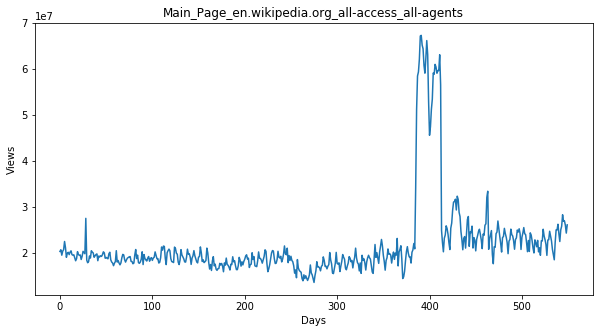

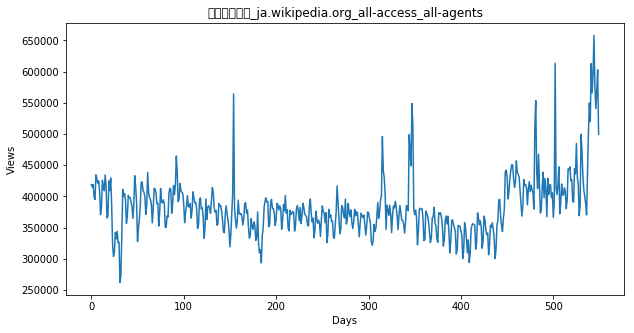

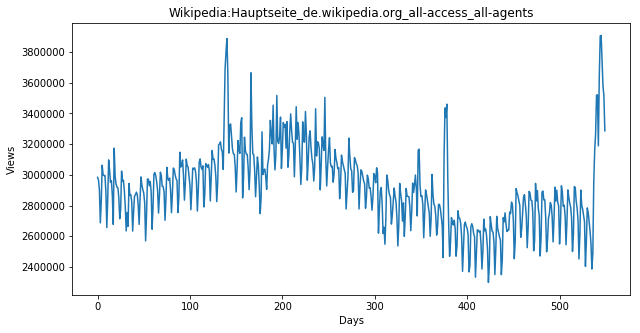

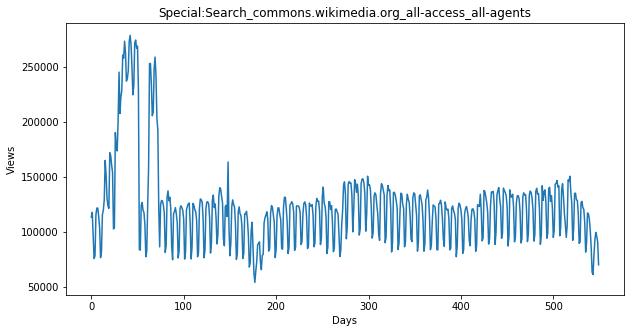

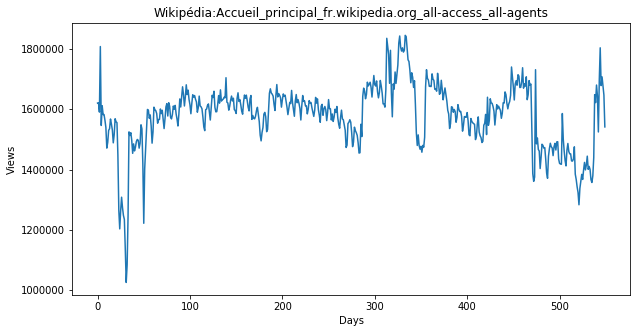

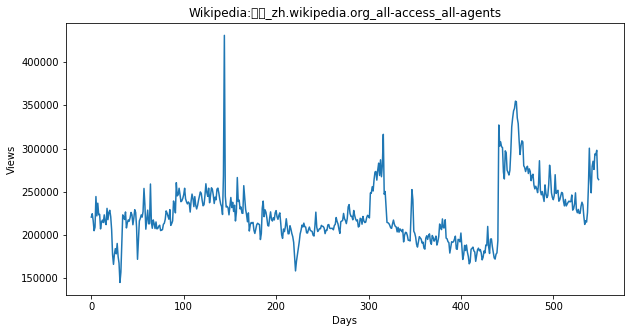

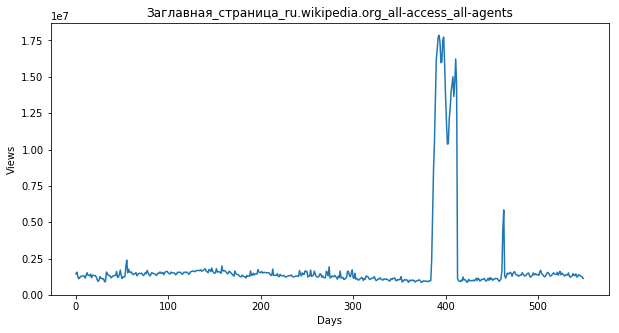

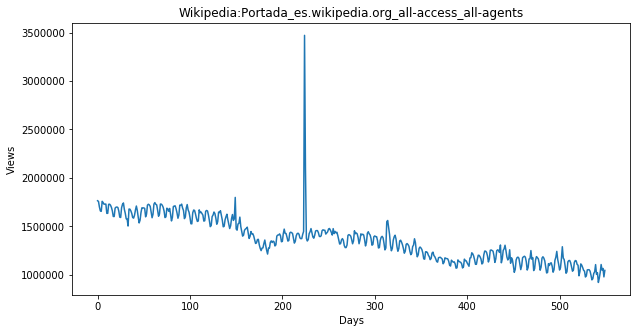

In [22]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train_1.columns
    cols = cols[1:-1]
    data = train_1.loc[top_pages[key],cols]
    plt.plot(days,data)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.title(train_1.loc[top_pages[key],'Page'])
    plt.show()

****More Analysis Tools****

**Notes**
* The statsmodel packages includes quite a few tools for doing time series analysis. Here, I will be showing the autocorrelation and partial autocorrelation for the most viewed pages for each langauge.
* Both of these show correlations of the signal with a delayed version of itself. At each lag, the partial autocorrelation tries to show the correlation at that lag after removing correlations at shorter lags.

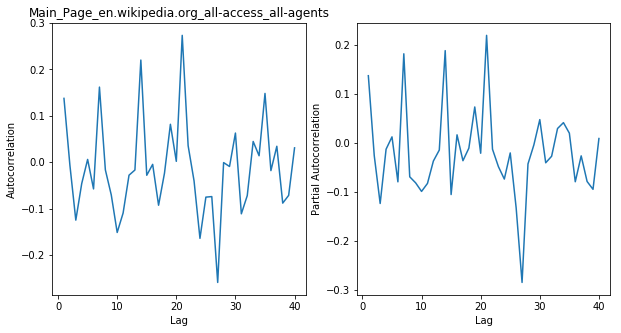

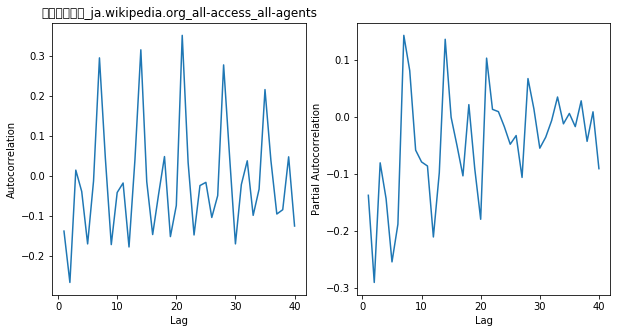

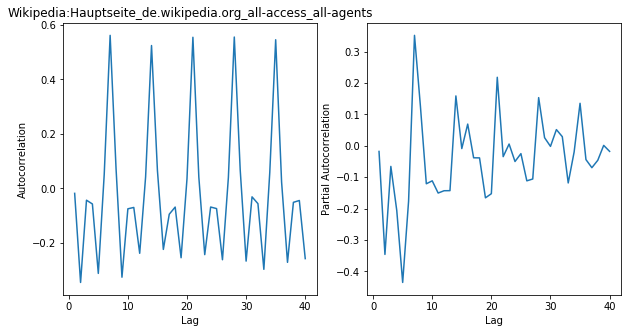

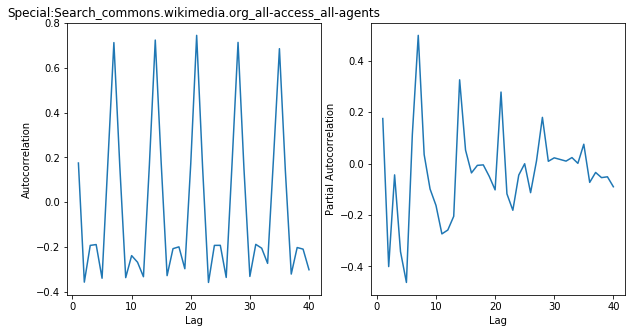

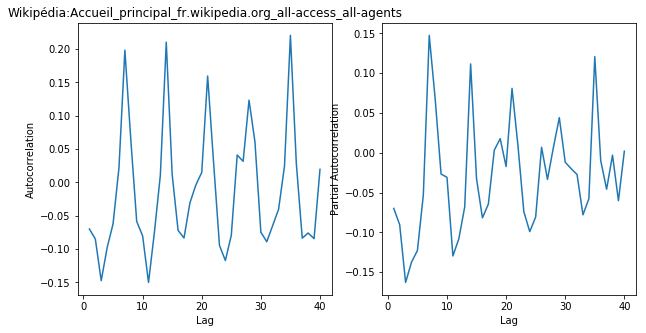

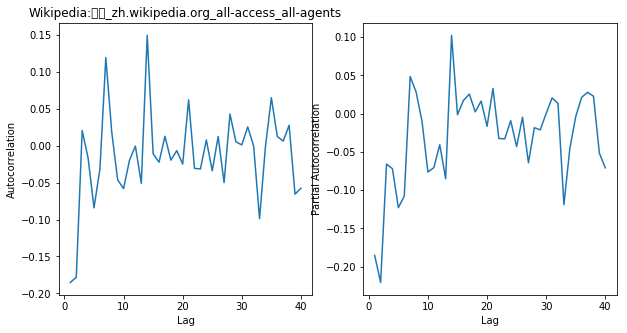

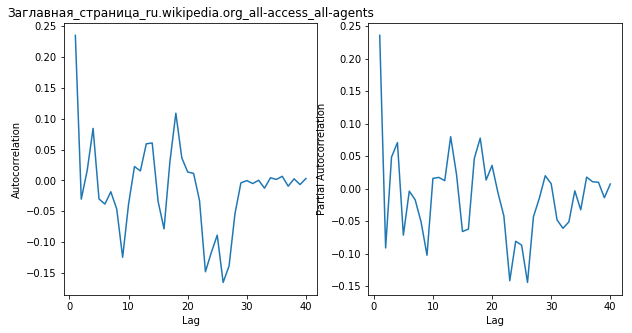

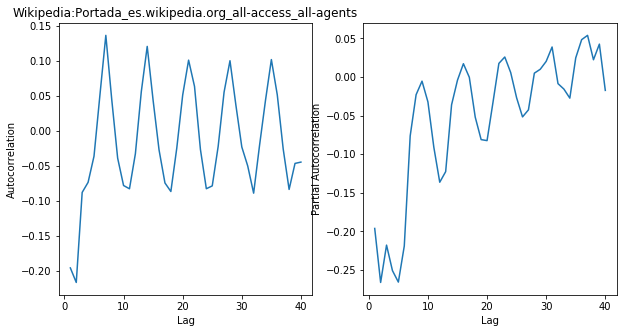

In [23]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in top_pages:
    fig= plt.figure(1, figsize= [10,5])
    ax1= fig.add_subplot(121)
    ax2= fig.add_subplot(122)
    cols= train_1.columns[1:-1]
    data= np.array(train_1.loc[top_pages[key], cols])
    data_diff= [data[i]- data[i-1] for i  in range(1, len(data))]
    autocorr= acf(data_diff)
    pac= pacf(data_diff)
    
    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train_1.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show()
    

**ARIMA Model**

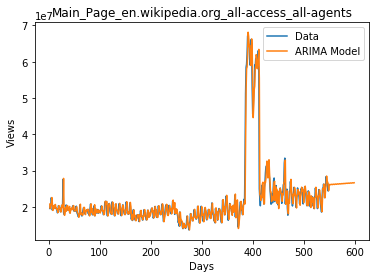

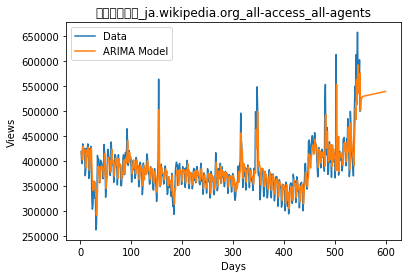

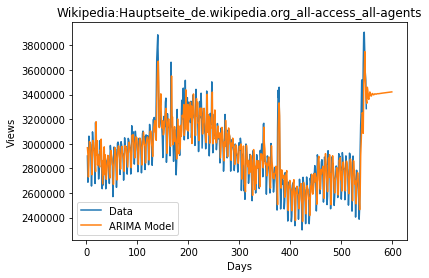

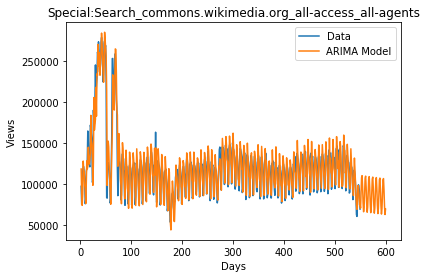

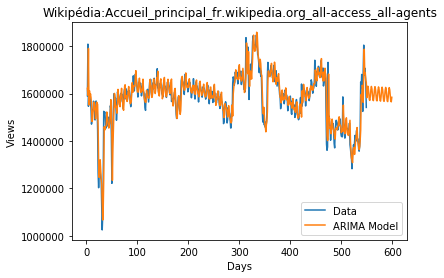

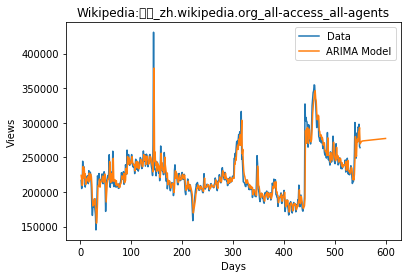

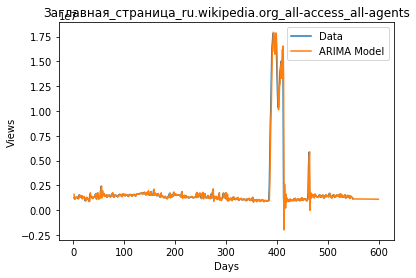

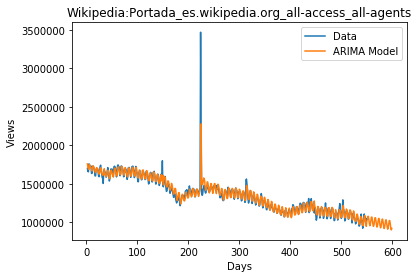

In [24]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols= train_1.columns[1:-1]
for key in top_pages:
    data= np.array(train_1.loc[top_pages[key],cols],"f")
    result= None
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            arima= ARIMA(data, [2,1,4])
            result= arima.fit(disp= False)
        except:
            try:
                arima= ARIMA(data, [2,1,2])
                result= arima.fit(disp= False)
            except:
                print(train_1.loc[top_pages[key], "Page"])
                print("\tARIMA FAILED")
    pred= result.predict(2,599, typ= "levels")
    x= [i for i in range(600)]
    i=0
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train_1.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    

**CONCLUSION**
* We see that the ARIMA model in some cases is able to predict the weekly substructure of the signal, which is good. In other cases it seems to just give a linear fit. This is potentially very useful.